In [62]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# import os

# os.chdir('drive/MyDrive/three-phase-fidelity-wip')
# print(os.getcwd())

# # # # !pip install -r requirements.txt
# !pip install ipython==7.31.1
# !pip install importlib-metadata==4.10.0
# !pip install acv-exp
# !pip install hyperopt==0.27
# # # ## !pip freeze > requirements.txt

# !pip install lime
# !pip install shap
# !pip install hyperopt

In [63]:
# !pip install scikit-learn==1.3.0 --user

In [64]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_percentage_error, accuracy_score, mean_squared_error, r2_score
import sklearn
from sklearn.utils.validation import check_symmetric
from sklearn.cluster import DBSCAN, HDBSCAN
from scipy.cluster import hierarchy
import scipy.spatial.distance as ssd

import os
import joblib

import warnings
warnings.filterwarnings('ignore')

import scipy

import shap
import lime
import learning
import pyAgrum
#from acv_explainers import ACXplainer

#from anchor import anchor_tabular

import json

from tqdm import tqdm, tqdm_notebook

from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

from collections import Counter
import seaborn as sns

In [65]:
# def get_shap_vals(explainer, instance, cls, classification, exp_iter, feat_list):
    
#     shap_exp = []
    
#     pred = cls.predict(instance.reshape(1, -1))
    
#     for i in range(exp_iter):
#         if type(explainer) == shap.explainers._tree.Tree:
#             exp = explainer(instance, check_additivity = False).values
#         else:
#             exp = explainer(instance.reshape(1, -1)).values
                
#         if exp.shape == (1, len(feat_list), 2):
#             exp = exp[0]
            
#         #print(exp.shape)
        
#         if exp.shape == (len(feat_list), 2):
#             exp = np.array([feat[pred] for feat in exp]).reshape(len(feat_list))
#         elif exp.shape == (1, len(feat_list)) or exp.shape == (len(feat_list), 1):
#             exp = exp.reshape(len(feat_list))
            
#         shap_exp.append(exp)
        
        
#     if np.array(shap_exp).shape != (exp_iter, len(feat_list)):
#         raise Exception("Explanation shape is not correct. It is", np.array(shap_exp).shape, "instead of the expected", (exp_iter, len(feat_list)))
            
#     avg_val = np.average(shap_exp, axis = 0)
#     abs_val = [abs(val) for val in avg_val]
    
#     return avg_val, abs_val

In [66]:
# def get_lime_features(explainer, instance, cls, classification, exp_iter, feat_list):
#     lime_exp = []
    
#     for i in range(exp_iter):
#         if classification==True:
#             lime_exp.extend(explainer.explain_instance(instance, cls.predict_proba, 
#                                                 num_features=len(feat_list), labels=[0,1]).as_list())
#         else:
#             lime_exp.extend(explainer.explain_instance(instance, cls.predict, 
#                                                 num_features=len(feat_list), labels=[0,1]).as_list())
            
#     weights = [[] for each in feat_list]
#     for exp in lime_exp:
#         feat = exp[0]
#         if '<' in feat:
#             feat = exp[0].replace("= ",'')
#             parts = feat.split('<')
#         elif '>' in feat:
#             feat = exp[0].replace("= ",'')
#             parts = feat.split('>')
#         else:
#             parts = feat.split("=")
        
#         for part in parts:
#             if part.replace('.','').replace(' ','').isdigit()==False:
#                 feat_name = part.replace(' ','')
#         n = feat_list.index(feat_name)
#         weights[n].append(exp[1])
    
#     weights = np.transpose(weights)
#     avg_weight = np.average(np.array(weights), axis = 0)
#     abs_weight = [abs(weight) for weight in avg_weight]
    
#     bins = pd.cut(abs_weight, 4, retbins = True, duplicates = "drop")
#     q1_min = bins[1][-2]
    
#     sorted_weight = np.copy(abs_weight)
#     sorted_weight.sort()
    
#     lime_features = [i for i in range(len(feat_list)) if abs_weight[i] >= q1_min]
    
#     return avg_weight, abs_weight

In [67]:
# def get_linda_features(instance, cls, scaler, dataset, exp_iter, feat_list):
#     label_lst = ["Negative", "Positive"]
    
#     feat_pos = []
#     lkhoods = []
    
#     for i in range(exp_iter):
#         [bn, inference, infoBN] = learning.generate_BN_explanations(instance, label_lst, feat_list, "Result", 
#                                                                        None, scaler, cls, save_to+"/"+cls_method+"/", dataset, show_in_notebook = False)
        
#         ie = pyAgrum.LazyPropagation(bn)
#         result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
#         result_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
#         row = instance['original_vector']
#         #print(row)

#         likelihood = [0]*len(feat_list)

#         for j in range(len(feat_list)):
#             var_labels = bn.variable(feat_list[j]).labels()
#             str_bins = list(var_labels)
#             bins = []

#             for disc_bin in str_bins:
#                 disc_bin = disc_bin.strip('"(]')
#                 cat = [float(val) for val in disc_bin.split(',')]
#                 bins.append(cat)

#             for k in range(len(bins)):
#                 if k == 0 and row[j] <= bins[k][0]:
#                     feat_bin = str_bins[k]
#                 elif k == len(bins)-1 and row[j] >= bins[k][1]:
#                     feat_bin = str_bins[k]
#                 elif row[j] > bins[k][0] and row[j] <= bins[k][1]:
#                     feat_bin = str_bins[k]

#             ie = pyAgrum.LazyPropagation(bn)
#             ie.setEvidence({feat_list[j]: feat_bin})
#             ie.makeInference()
            
#             result_posterior = ie.posterior(bn.idFromName("Result")).topandas()
#             new_proba = result_posterior.loc["Result", label_lst[instance['predictions']]]
#             #print(result_proba, new_proba)
#             proba_change = result_proba-new_proba
#             likelihood[j] = abs(proba_change)

#         lkhoods.append(likelihood)
        
#     bins = pd.cut(np.mean(lkhoods, axis=0), 4, retbins = True, duplicates = "drop")
#     q1_min = bins[1][-2]

#     #If fixing all features produces the same result for the class,
#     #return all features
#     if len(set(np.mean(lkhoods, axis=0)))==1:
#         feat_pos.extend(range(len(feat_list)))
#         #print(lkhoods)
#     else:
#         feat_pos.extend(list(np.where(np.mean(lkhoods, axis=0) >= q1_min)[0]))

#     feat_pos = set(feat_pos)
#     #print(feat_pos)
    
#     return np.mean(lkhoods, axis=0), np.mean(lkhoods, axis=0)

In [68]:
# def get_acv_features(explainer, instance, cls, X_train, y_train, exp_iter, feat_list):
#     instance = instance.reshape(1, -1)
#     y = cls.predict(instance)

#     feat_pos = []
#     feat_imp = []

#     for i in range(exp_iter):
#         sdp_importance, sdp_index, size, sdp = explainer.importance_sdp_rf(instance, y, X_train, y_train)
#         feat_pos.extend(sdp_index[0, :size[0]])
        
#         sufficient_expl, sdp_expl, sdp_global = explainer.sufficient_expl_rf(instance, y, X_train, y_train)
#         #print(np.array(sufficient_expl).shape)
#         lximp = explainer.compute_local_sdp(len(feat_list), sufficient_expl[0])
#         feat_imp.append(lximp)


#     feats = Counter(feat_pos)
#     imp = feats.items()

#     occ = np.zeros(len(feat_list))

#     for each in imp:
#         occ[each[0]] = each[1]
        
#     avg_imp = np.mean(feat_imp, axis=0)
#     abs_imp = [abs(imp) for imp in avg_imp]

#     print("Frequency of occurrence:", occ)
#     #print("Feature importance score:", avg_imp)
#     return occ, occ
#     #return avg_imp, abs_imp

In [69]:
# def get_anchor_features(explainer, instance, cls, train_data, classification, exp_iter):
#     anchor_exp = []
#     for i in range(exp_iter):
#         if classification == True:
#             anchor_exp.extend(explainer.explain_instance(instance, cls.predict).names())
#     print(anchor_exp)

#     locs = []
#     for exp in anchor_exp:
#         feat = exp.replace("= ",'')
#         #print(feat)
#         if '<' in feat:
#             parts = feat.split('<')
#             #print("less than", parts)
#         elif '>' in feat:
#             parts = feat.split('>')
#             #print("more than", parts)

#         for part in parts:
#             if part.replace('.','').replace(' ','').isdigit()==False:
#                 feat_name = part.replace(' ','')
#         locs.append(feat_list.index(feat_name))
    
#     feats = Counter(locs)
#     imp = feats.items()
    
#     #print(imp)
    
#     occ = np.zeros(len(feat_list))
    
#     for each in imp:
#         occ[each[0]] = each[1]
        
#     print("Frequency of occurrence:", occ)
    
#     return occ, occ

In [70]:
# def get_explanation_features(explainer, instance, cls, scaler, dataset, classification, exp_iter, xai_method, feat_list, X_train, y_train):
#     if xai_method == "SHAP":
#         feat_pos = get_shap_vals(explainer, instance, cls, classification, exp_iter, feat_list)
        
#     elif xai_method == "LIME":
#         feat_pos = get_lime_features(explainer, instance, cls, classification, exp_iter, feat_list)
        
#     elif xai_method == "LINDA":
#         feat_pos = get_linda_features(instance, cls, scaler, dataset, exp_iter, feat_list)

#     elif xai_method == "ACV":
#         feat_pos = get_acv_features(explainer, instance, cls, X_train, y_train, exp_iter, feat_list)
        
#     elif xai_method == "Anchor":
#         feat_pos = get_anchor_features(explainer, instance, cls, X_train, classification, exp_iter)
    
#     return feat_pos

In [71]:
def get_tree_features(cls, instance):
    tree = cls.tree_
    lvl = 0
    left_child = tree.children_left[lvl]
    right_child = tree.children_right[lvl]

    feats = []
    
    while left_child != sklearn.tree._tree.TREE_LEAF and right_child != sklearn.tree._tree.TREE_LEAF:
        feature = tree.feature[lvl]
        feats.append(feature)
        
        if instance[feature] < tree.threshold[lvl]:
            lvl = left_child
        else:
            lvl = right_child
            
        left_child = tree.children_left[lvl]
        right_child = tree.children_right[lvl]
            
            
    feat_pos = np.zeros(len(instance))
    n = len(feats)
    for i in feats:
        feat_pos[i]+=n
#        feat_pos[i]+=1
        n=n-1
    #feat_pos = set(feats)
    
    return feat_pos

In [72]:
def get_reg_features(cls):

    og_coef = cls.coef_
    if len(og_coef.shape) > 1:
        og_coef = og_coef[0]
    
    coef = [abs(val) for val in og_coef]
    
#     bins = pd.cut(coef, 4, retbins = True, duplicates = "drop")
#     q1_min = bins[1][-2]
    
#     feat_pos = [i for i in range(len(coef)) if coef[i] > q1_min]
    
    return coef

In [73]:
def get_nb_features(cls, instance):
    pred = cls.predict(instance.reshape(1, -1))
    means = cls.theta_[pred][0]
    std = np.sqrt(cls.var_[pred])[0]
    
    alt = 1-pred
    alt_means = cls.theta_[alt][0]
    alt_std = np.sqrt(cls.var_[alt])[0]

    likelihoods = []
    
    for i in range(len(means)):
        lk = scipy.stats.norm(means[i], std[i]).logpdf(instance[i])
        alt_lk = scipy.stats.norm(alt_means[i], alt_std[i]).logpdf(instance[i])
        lkhood = lk-alt_lk
#        lkhood = scipy.stats.norm(means[i], std[i]).logpdf(instance[i])
        likelihoods.append(lkhood)
    
#     bins = pd.cut(likelihoods, 4, retbins = True, duplicates = "drop")[1]
#     lim = bins[-2]
    
# #     bins = pd.cut(likelihoods, 10, retbins = True, duplicates = "drop")[1]
# #     lim_1 = bins[-2]
# #     lim_2 = bins[1]
    
# #     sortedls = sorted(likelihoods, reverse=True)
# #     pos = math.ceil(len(likelihoods)/4)
# #     lim = likelihoods[pos]
    
#     feat_pos = [i for i in range(len(likelihoods)) if likelihoods[i] >= lim]# or likelihoods[i] <= lim_2]
    
    return np.abs(likelihoods)

In [74]:
def get_true_rankings(cls, instance, cls_method, X_train, feat_list):
    if cls_method == "decision_tree":
        feat_pos = get_tree_features(cls, instance)
        
    elif cls_method == "logit" or cls_method == "lin_reg":
        feat_pos = get_reg_features(cls)
        
    elif cls_method == "nb":
        feat_pos = get_nb_features(cls, instance)
        
    return feat_pos

In [75]:
def permute_instance(instance, i, perm_iter = 100, min_i = 0, max_i=1, mean_i=0, mode="permutation"):
    if mode=="baseline_max":
        n_val = [max_i]*perm_iter
    elif mode=="baseline" or mode=="baseline_mean":
        n_val = [mean_i]*perm_iter
    elif mode=="baseline_min":
        n_val = [min_i]*perm_iter
    elif mode=="baseline_0":
        n_val = [0]*perm_iter
    else:
        n_val = np.random.uniform(min_i, max_i, perm_iter)
    
    permutations = np.array([instance]*perm_iter).transpose()
    permutations[i] = n_val
    permutations = permutations.transpose()

    return permutations

In [76]:
def cycle_values(instance, i, perm_iter = 100, min_i = 0, max_i=1, mean_i=0, unique_values=[0,1], mode="permutation"):
    if mode=="baseline_max":
        n_val = [max_i]*perm_iter
    elif mode=="baseline" or mode=="baseline_mean":
        n_val = [mean_i]*perm_iter
    elif mode=="baseline_min":
        n_val = [min_i]*perm_iter
    elif mode=="baseline_0":
        n_val = [0]*perm_iter
    else:
        n_val = np.random.choice(unique_values, perm_iter)
    
    permutations = np.array([instance]*perm_iter).transpose()
    permutations[i] = n_val
    permutations = permutations.transpose()

    return permutations

In [77]:
# path to project folder
# please change to your own
PATH = os.getcwd()

dataset = "nursery"
cls_method = "nb"

classification = True
# xai_method = "SHAP"

modes = ["permutation", "baseline_min", "baseline_mean", "baseline_max", "baseline_0"]

random_state = 22
exp_iter = 10
perm_iter = 1000

save_to = "%s/%s/" % (PATH, dataset)
dataset_folder = "%s/datasets/" % (save_to)
final_folder = "%s/%s/" % (save_to, cls_method)

#Get datasets
X_train = pd.read_csv(dataset_folder+dataset+"_Xtrain.csv", index_col=False, sep = ";")
y_train = pd.read_csv(dataset_folder+dataset+"_Ytrain.csv", index_col=False, sep = ";")
test_x = pd.read_csv(final_folder+"test_sample.csv", index_col=False, sep = ";").values
results = pd.read_csv(os.path.join(final_folder,"results.csv"), index_col=False, sep = ";")
actual = results["Actual"].values

with open(dataset_folder+"col_dict.json", "r") as f:
    col_dict = json.load(f)
f.close()

feat_list = [each.replace(' ','_') for each in X_train.columns]

cls = joblib.load(save_to+cls_method+"/cls.joblib")
scaler = joblib.load(save_to+"/scaler.joblib")

In [78]:
# if xai_method == "SHAP":
#   #  explainer = shap.explainers._permutation.Permutation(cls.predict_proba, X_train)
#     if cls_method == "xgboost" or cls_method == "decision_tree":
#         explainer = shap.Explainer(cls)
#     elif cls_method == "nb":
#         if classification:
#             masker = shap.maskers._tabular.Independent(X_train.values, len(X_train))
#             explainer = shap.Explainer(cls.predict_proba, masker)
#         else:
#             print("NB is classification only")
#     elif cls_method == "logit" or cls_method == "lin_reg":
#         masker = shap.maskers._tabular.Independent(X_train.values, len(X_train))
#         explainer = shap.Explainer(cls, masker)
#     else:
#         explainer = shap.Explainer(cls, X_train)
#     print(type(explainer))
    
# elif xai_method == "LIME":
#     if col_dict['discrete'] != None:
#         cat_cols = [each.replace(' ','_') for each in col_dict['discrete']]
#         col_inds = [feat_list.index(each) for each in cat_cols]
#     else:
#         col_inds = []
    
#     if classification==True:
#         class_names=['Negative','Positive']# negative is 0, positive is 1, 0 is left, 1 is right
#         explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
#                                                             class_names=class_names, categorical_features = col_inds,
#                                                             discretize_continuous=False)
#     else:
#         class_names = ['Final Value']
#         explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names = feat_list, 
#                                                            class_names=class_names, discretize_continuous=True, 
#                                                            categorical_features = col_inds, mode = "regression")
        
# elif xai_method == "LINDA":
#     test_dict = learning.generate_local_predictions( test_x, results["Actual"].values, cls, scaler, None )
# #    feat_list = feat_list+["Result"]

#     explainer = None

# elif xai_method == "ACV":
#     explainer = joblib.load(save_to+cls_method+"/acv_explainer.joblib")
    
# elif xai_method == "Anchor":
#     if classification:
#         class_names=['Negative','Positive']
#         explainer = anchor_tabular.AnchorTabularExplainer(class_names, feat_list, X_train.values)
#     else:
#         raise Exception("Anchor only works for classification")

In [79]:
# if cls_method == "nb":
    
#     probas = cls.predict_proba(test_x)[:, 1]
    
#     clf_isotonic = CalibratedClassifierCV(cls, cv="prefit", method="isotonic")
#     clf_isotonic.fit(X_train, y_train)
#     isotonic_probas = clf_isotonic.predict_proba(test_x)[:, 1]
    
#     clf_sigmoid = CalibratedClassifierCV(cls, cv="prefit", method="sigmoid")
#     clf_sigmoid.fit(X_train, y_train)
#     sigmoid_probas = clf_sigmoid.predict_proba(test_x)[:, 1]
    
#     cls_score = brier_score_loss(results["Actual"], probas)
#     iso_score = brier_score_loss(results["Actual"], isotonic_probas)
#     sig_score = brier_score_loss(results["Actual"], sigmoid_probas)
    
#     if iso_score < sig_score and iso_score < cls_score:
#         print("Winner is iso")
#         cls = clf_isotonic.calibrated_classifiers_[0].base_estimator
#     elif sig_score < iso_score and sig_score < cls_score:
#         print("Winner is sigmoid")
#         cls = clf_sigmoid.calibrated_classifiers_[0].base_estimator
#     else:
#         cls = cls

In [80]:
min_X = np.min(X_train)
max_X = np.max(X_train)
mean_X = np.mean(X_train, axis=0)
unique_values = pd.Series({col: X_train[col].unique() for col in X_train.columns})

In [81]:
unique_values

parents_great_pret      [0.0, 1.0]
parents_pretentious     [0.0, 1.0]
parents_usual           [1.0, 0.0]
has_nurs_critical       [0.0, 1.0]
has_nurs_improper       [0.0, 1.0]
has_nurs_less_proper    [0.0, 1.0]
has_nurs_proper         [0.0, 1.0]
has_nurs_very_crit      [1.0, 0.0]
form_complete           [0.0, 1.0]
form_completed          [1.0, 0.0]
form_foster             [0.0, 1.0]
form_incomplete         [0.0, 1.0]
children_1              [0.0, 1.0]
children_2              [0.0, 1.0]
children_3              [0.0, 1.0]
children_more           [1.0, 0.0]
housing_convenient      [1.0, 0.0]
housing_critical        [0.0, 1.0]
housing_less_conv       [0.0, 1.0]
finance_convenient      [0.0, 1.0]
finance_inconv          [1.0, 0.0]
social_nonprob          [0.0, 1.0]
social_problematic      [1.0, 0.0]
social_slightly_prob    [0.0, 1.0]
health_not_recom        [0.0, 1.0]
health_priority         [0.0, 1.0]
health_recommended      [1.0, 0.0]
dtype: object

In [82]:
col_dict

{'continuous': None,
 'discrete': ['parents_great_pret',
  'parents_pretentious',
  'parents_usual',
  'has_nurs_critical',
  'has_nurs_improper',
  'has_nurs_less_proper',
  'has_nurs_proper',
  'has_nurs_very_crit',
  'form_complete',
  'form_completed',
  'form_foster',
  'form_incomplete',
  'children_1',
  'children_2',
  'children_3',
  'children_more',
  'housing_convenient',
  'housing_critical',
  'housing_less_conv',
  'finance_convenient',
  'finance_inconv',
  'social_nonprob',
  'social_problematic',
  'social_slightly_prob',
  'health_not_recom',
  'health_priority',
  'health_recommended']}

<AxesSubplot:>

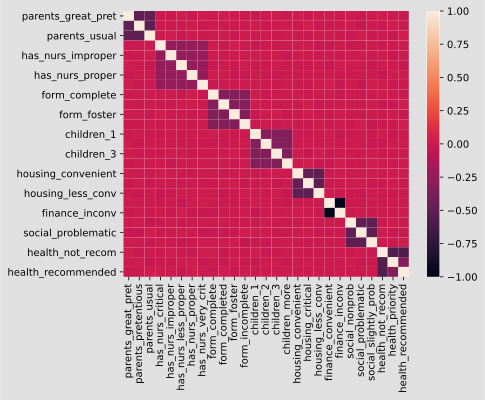

In [83]:
corr = X_train.corr().fillna(0)
np.fill_diagonal(corr.values, 1)
# a = np.where(np.triu(corr, k=1)==0, np.nan,corr)
# corr = np.where(np.isnan(a), a.T, a)
distances = 1-corr.abs().values
sns.heatmap(corr)

In [84]:
clusters = HDBSCAN(min_cluster_size=2, metric="manhattan", cluster_selection_method="eom").fit_predict(distances)

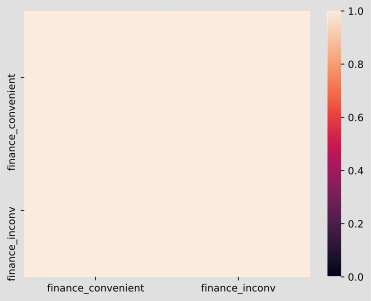

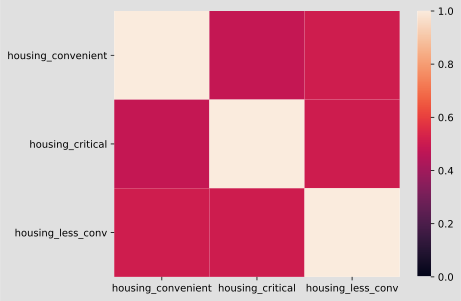

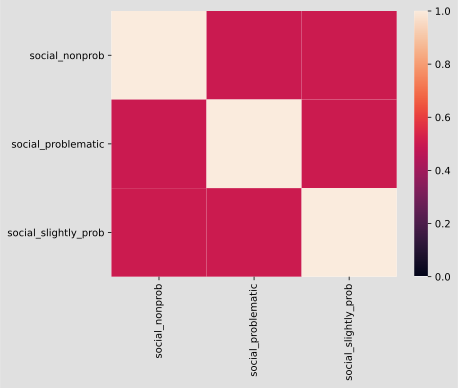

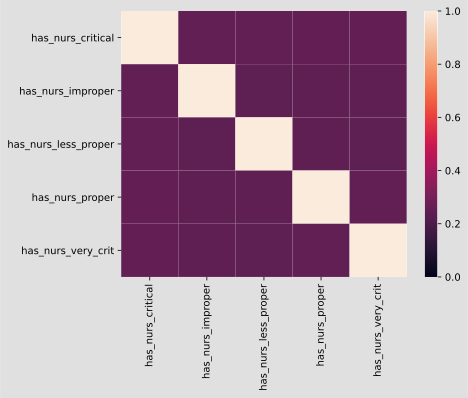

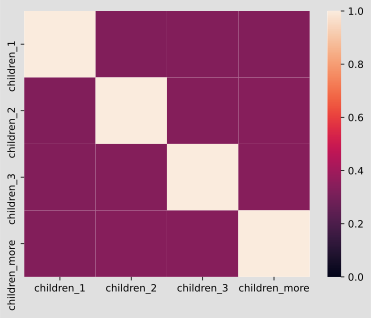

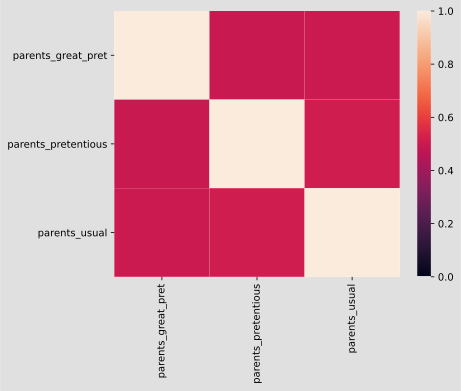

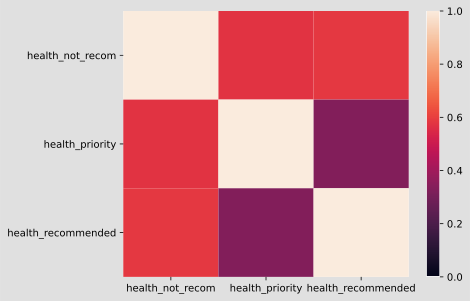

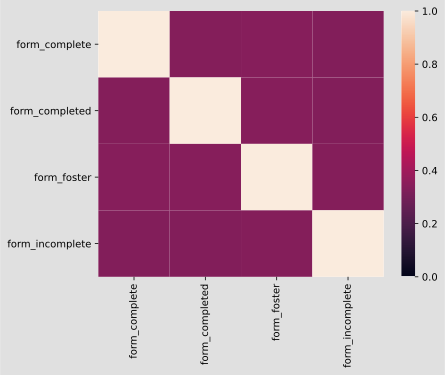

In [85]:
import matplotlib.pyplot as plt
for each in np.unique(clusters):
    ind = np.where(clusters==each)
    rel_cols = X_train.columns[ind]
    sns.heatmap(X_train[rel_cols].corr().abs(),vmin=0, vmax=1)
    plt.show()

<AxesSubplot:>

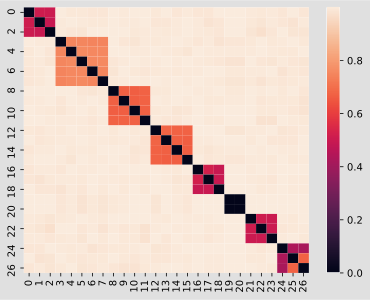

In [270]:
sns.heatmap(distances)

In [63]:
X_train.shape

(10977, 104)

In [22]:
for mode in modes:
    ktb_list = []
    true_v_mape = []
    true_v_rmse = []
    true_v_r2 = []

    for i in tqdm_notebook(range(len(test_x))):
        instance = test_x[i]

        tr = get_true_rankings(cls, instance, cls_method, X_train, feat_list)

        if classification:
            pred = cls.predict(instance.reshape(1, -1))
            proba = cls.predict_proba(instance.reshape(1, -1)).reshape(2)[pred]
    #        p1_list = [pred]*perm_iter
            p1_list = list(proba)*perm_iter
#         else:
#             pred = cls.predict(instance.reshape(1, -1)).reshape(1)
#             p1_list = [pred]*perm_iter

    #     pred = cls.predict(instance.reshape(1, -1)).reshape(1)
    #     p1_list = [pred]*perm_iter

        perm_mape = np.zeros(len(instance))
        perm_rmse = np.zeros(len(instance))
        perm_r2 = np.zeros(len(instance))

        for j in range(len(instance)):
           # print("Permuting", feat_list[j])

            if col_dict["continuous"] != None:
                if X_train.columns[j] in col_dict["continuous"]:
                    permutations = permute_instance(instance, j, perm_iter, min_X[j], max_X[j], mean_X[j], mode)
                else:
                    permutations = cycle_values(instance, j, perm_iter, min_X[j], max_X[j], mean_X[j], unique_values[X_train.columns[j]], mode)
            else:
                permutations = cycle_values(instance, j, perm_iter, min_X[j], max_X[j], mean_X[j], unique_values[X_train.columns[j]], mode)

            if classification:
    #             p2_list = cls.predict_proba(permutations)[:, pred].reshape(perm_iter)
    #             perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)

                p2_list = cls.predict_proba(permutations).transpose()[pred].reshape(perm_iter)
           #     perm_acc[j] = 1-accuracy_score(p1_list, p2_list)
                perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)
                perm_rmse[j] = mean_squared_error(p1_list, p2_list, squared=False)
                perm_r2[j] = r2_score(p1_list, p2_list)

    #             perm_mape[j] = len([np for np in new_preds if np!=pred])
    #             print(pred)
    #             print(new_preds)
    #             print(perm_mape[j])
#            else:
#                 p2_list = cls.predict(permutations).reshape(perm_iter)
#                 perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)

            #p2_list = cls.predict(permutations).reshape(perm_iter)
            #perm_mape[j] = mean_absolute_percentage_error(p1_list, p2_list)

        #print("Final MAPE for all features:", perm_mape)
        mape_corr = scipy.stats.kendalltau(tr, perm_mape, variant="b")[0]
        rmse_corr = scipy.stats.kendalltau(tr, perm_rmse, variant="b")[0]
        r2_corr = scipy.stats.kendalltau(tr, perm_r2, variant="b")[0]

        #if xai_method=="LINDA":
        #    instance = test_dict[i]

        #avg_explanation, abs_explanation = get_explanation_features(explainer, instance, cls, scaler, dataset, classification, exp_iter, xai_method, 
        #                                                        feat_list, X_train.values, y_train)
        #print("Average explanation:", abs_explanation)

        #if np.all(abs_explanation==abs_explanation[0]):
        #    ktb=0
        #else:
        #    ktb = scipy.stats.kendalltau(perm_mape, abs_explanation, variant="b")[0]

      #  ktb_list.append(ktb)
        true_v_mape.append(mape_corr)
        true_v_rmse.append(rmse_corr)
        true_v_r2.append(r2_corr)

    #results[xai_method+"_KT-B"] = ktb_list
    results["MAPE Correctness"] = true_v_mape
    results["RMSE Correctness"] = true_v_rmse
    results["R2 Correctness"] = true_v_r2
    results.to_csv(os.path.join(save_to, cls_method, mode+"_results.csv"), index = False, sep = ";")


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [23]:
# p2_list

In [24]:
# p2_list.shape